## Graph kernels for detecting change points

Here, I'm using successive perturbations on the links between pocket gophers and chewing lice from Hafner *et al.* to see how well graph kernels can recover the magnitude of the the perturbation.

* [**Disparate rates of molecular evolution in cospeciating hosts and parasites**](http://science.sciencemag.org/content/265/5175/1087), by Hafner MS, Sudman PD, Villablanca FX, Spradling TA, Demastes JW, Nadler SA (doi:10.1126/science.8066445)

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees
import graphkernels.kernels as gk
import igraph
import pandas
import seaborn
import json
import pyprind

In [3]:
T1 = SuchTree( '../SuchTree/data/gopher-louse/gopher.tree' )
T2 = SuchTree( '../SuchTree/data/gopher-louse/lice.tree' )
LK = pandas.read_csv( '../SuchTree/data/gopher-louse/links.csv', index_col=0 )
SLT = SuchLinkedTrees( T1, T2, LK )

This is what the graph looks like without perturbations...

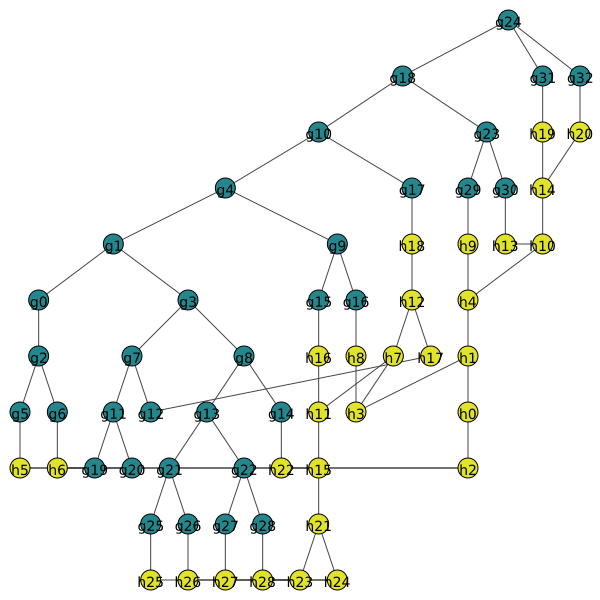

In [4]:
g = SLT.to_igraph( swaps=0 )

igraph.plot( g, layout=g.layout_reingold_tilford() )

...and after 15 host-parasite links have been randomly removed.

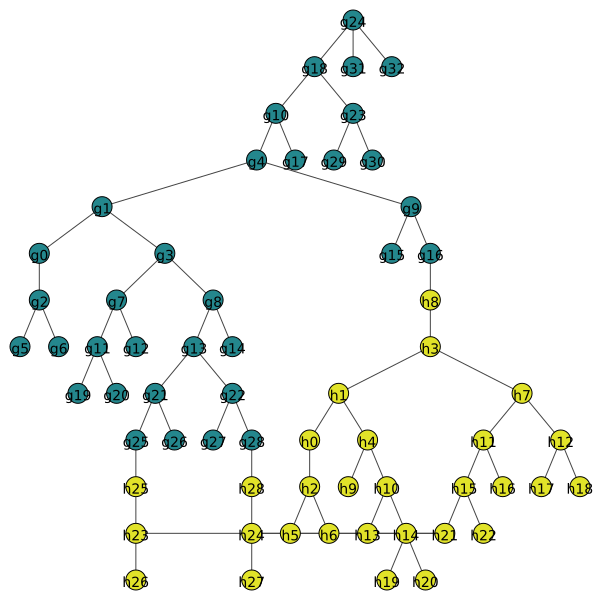

In [5]:
g = SLT.to_igraph( deletions=15 )

igraph.plot( g, layout=g.layout_reingold_tilford() )

Geraph kernels, being based on the direct product graph, function a bit like
scalar products of graphs. Reasoning by analogy, we can use graph kernels to
construct a distance function.

For a graph kernel $G_k(A,B)$ that yeilds a scalar product of graphs $A$ and $B$,
we would like a function $d_k(A,B)$ that behaves like a distnace function. For vectors,

$ d^2 = \|\vec{B} - \vec{A}\| = (\vec{B}-\vec{A}) \cdot (\vec{B}-\vec{A}) \\
      = \vec{B} \cdot \vec{B} - \vec{B} \cdot \vec{A} - \vec{A} \cdot \vec{B} + \vec{A} \cdot \vec{A} \\
      = \| \vec{B} \|^2 - 2\vec{B} \cdot \vec{A} + \| \vec{A} \|^2 $
      
If $d_k(A,B)$ behaves like $d(\vec{A},\vec{B})$, then :

$d_k(A,B) = G_k(B,B) - 2G_k(B,A) + G_k(A,A)$

Using connected graphlet kernel, this seems to recover the order very well :

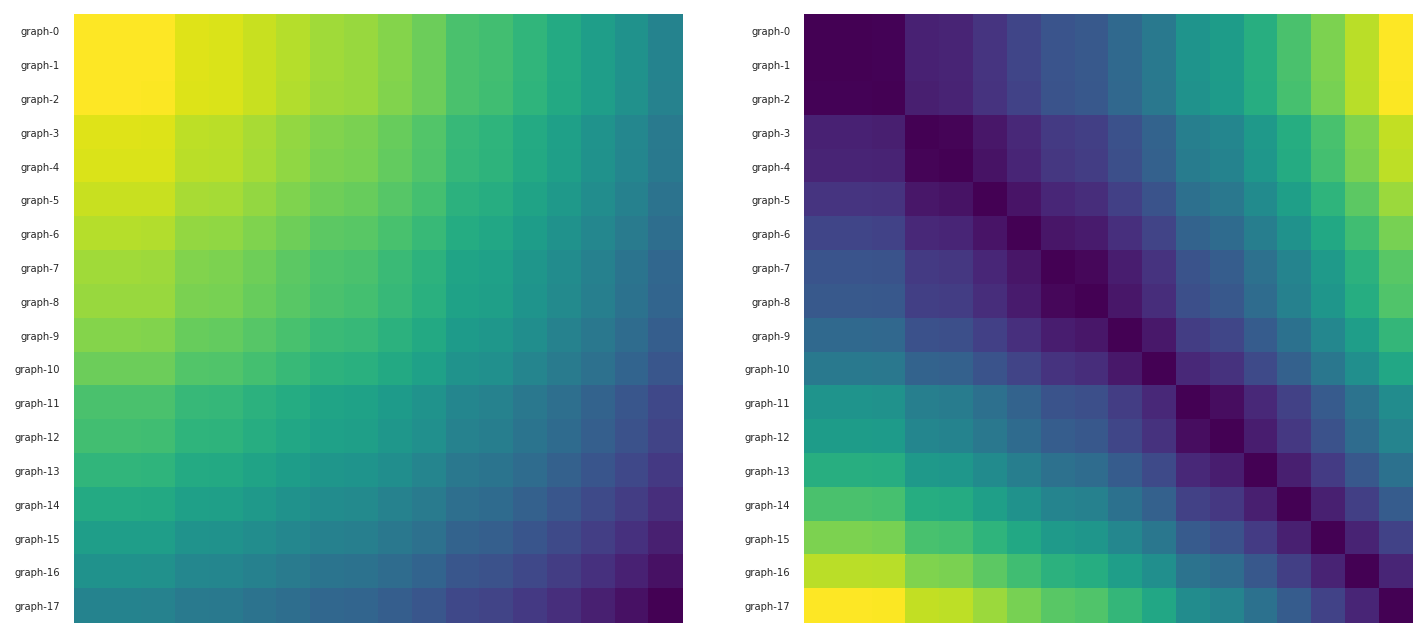

In [31]:
names, graphs = [],[]
for i in range( 0, 18, 1 ) :
    names.append( 'graph-' + str(i) )
    graphs.append( SLT.to_igraph( deletions=i ) )
    
K = gk.CalculateConnectedGraphletKernel( graphs )

d = zeros( K.shape )
for i in range( K.shape[0] ) :
    for j in range( K.shape[1] ) :
        d[i,j] = sqrt( K[j,j] - 2*K[j,i] + K[i,i] )

figure( figsize=(12,6) )

subplot(1,2,1)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( K, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )

subplot(1,2,2)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( d, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )


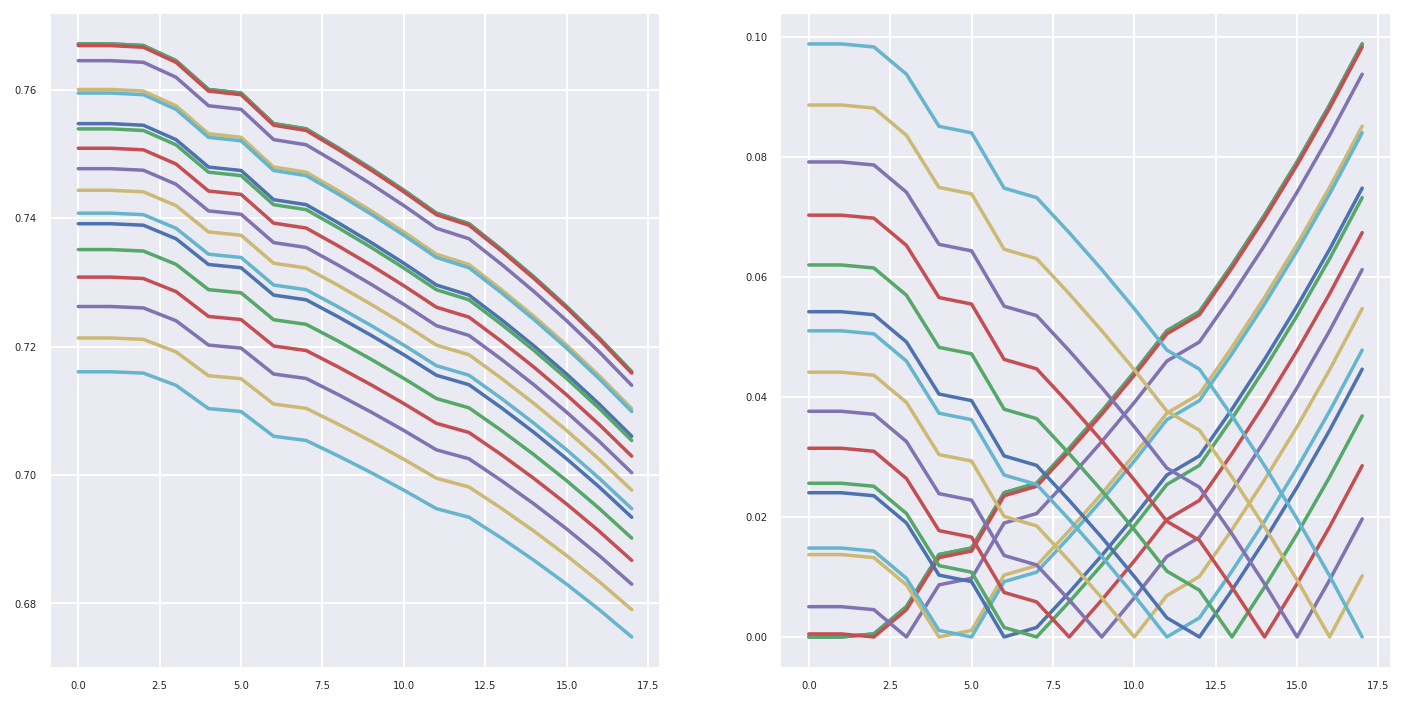

In [11]:
figure( figsize=(12,6) )

subplot(1,2,1)
for i in range( 0, 18, 1 ) :
    plot( K[i] )
    
subplot(1,2,2)
for i in range( 0, 18, 1 ) :
    plot( d[i] )

It seems to obey the triangle inequality, at least approximately.

In [41]:
tri = []
for i in range( d.shape[0] ) :
    for j in range( d.shape[1] ) :
        for k in range( d.shape[0] ) :
            tri.append((d[i,k] + d[k,j]) - d[i,j])

In [47]:
min(tri), max(tri), mean(tri)

(-1.7579340760853768e-13, 0.1975668058069596, 0.034901084022259776)

Adding random links seems to work as well, though it's noisier.

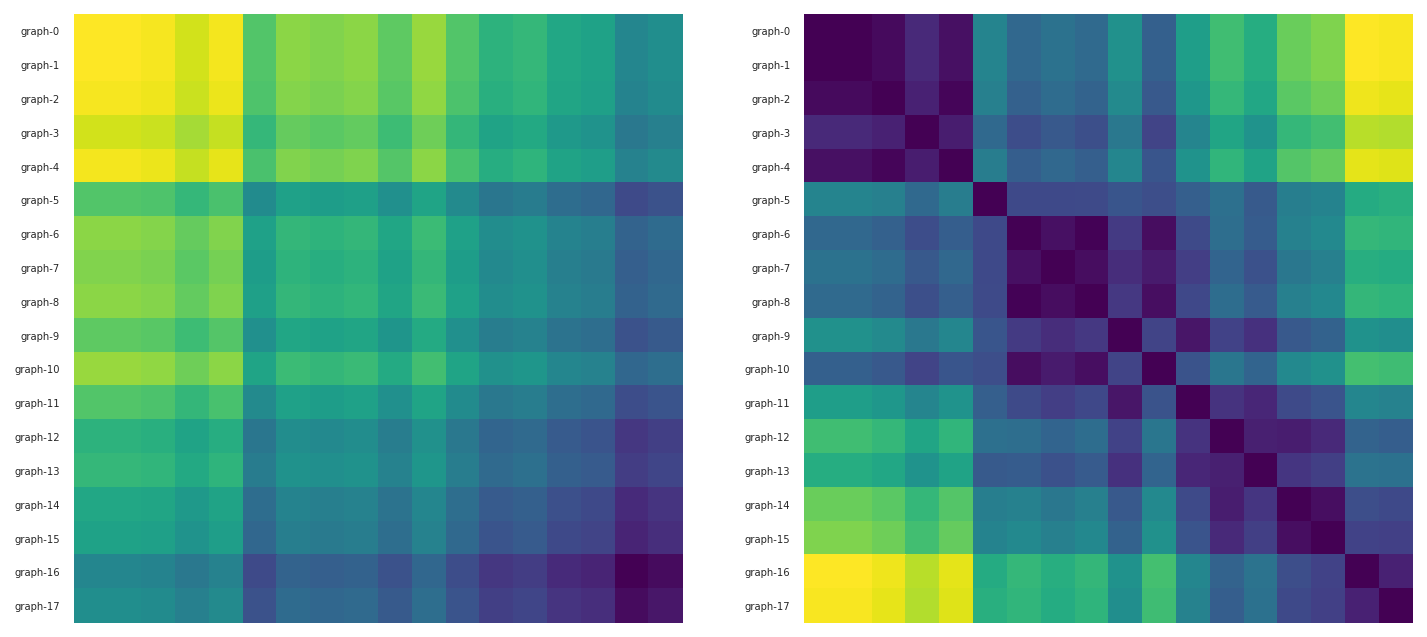

In [12]:
names, graphs = [],[]
for i in range( 0, 18, 1 ) :
    names.append( 'graph-' + str(i) )
    graphs.append( SLT.to_igraph( additions=i ) )

K = gk.CalculateConnectedGraphletKernel( graphs )

d = zeros( K.shape )
for i in range( K.shape[0] ) :
    for j in range( K.shape[1] ) :
        d[i,j] = sqrt( K[j,j] - 2*K[j,i] + K[i,i] )

figure( figsize=(12,6) )

subplot(1,2,1)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( K, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )

subplot(1,2,2)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( d, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )

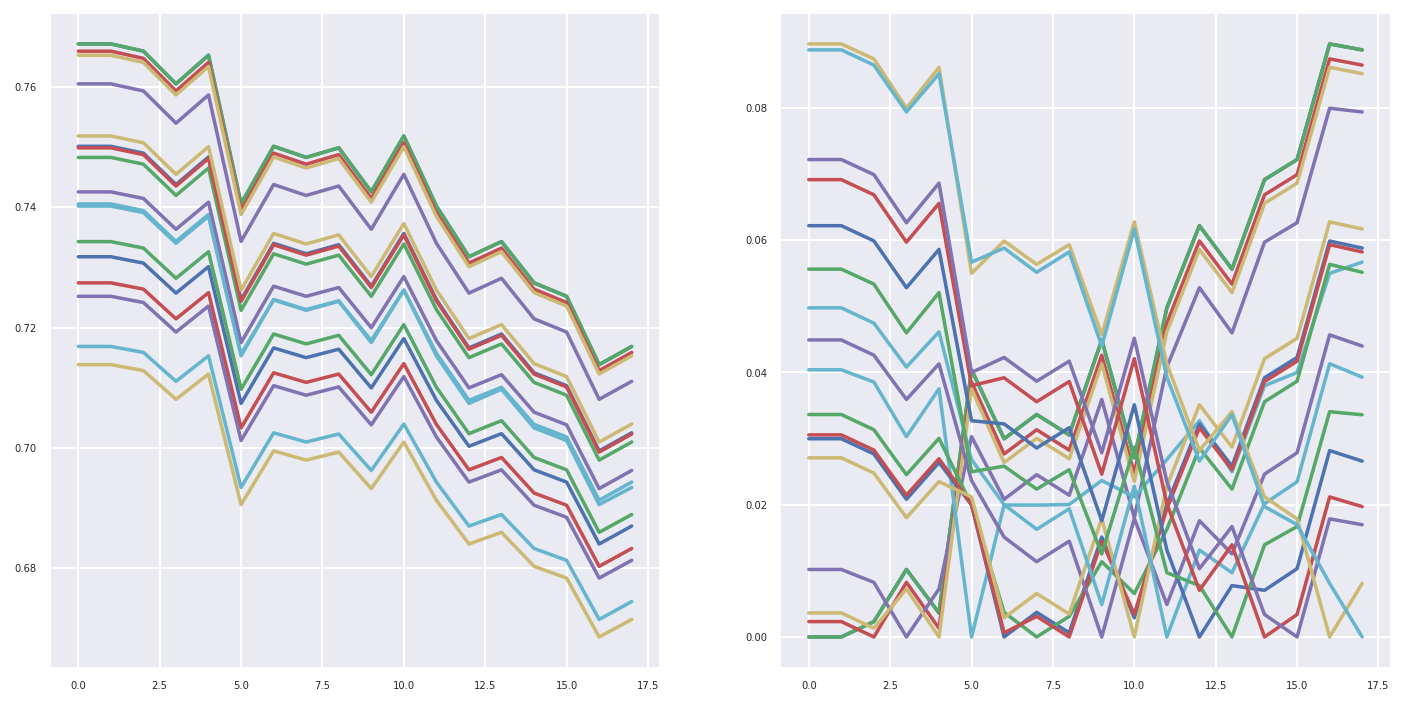

In [13]:
figure( figsize=(12,6) )

subplot(1,2,1)
for i in range( 0, 18, 1 ) :
    plot( K[i] )
    
subplot(1,2,2)
for i in range( 0, 18, 1 ) :
    plot( d[i] )

The connected graphlet kernel doesn't seem very sensitive to permutation of the host-parasite associations, though.

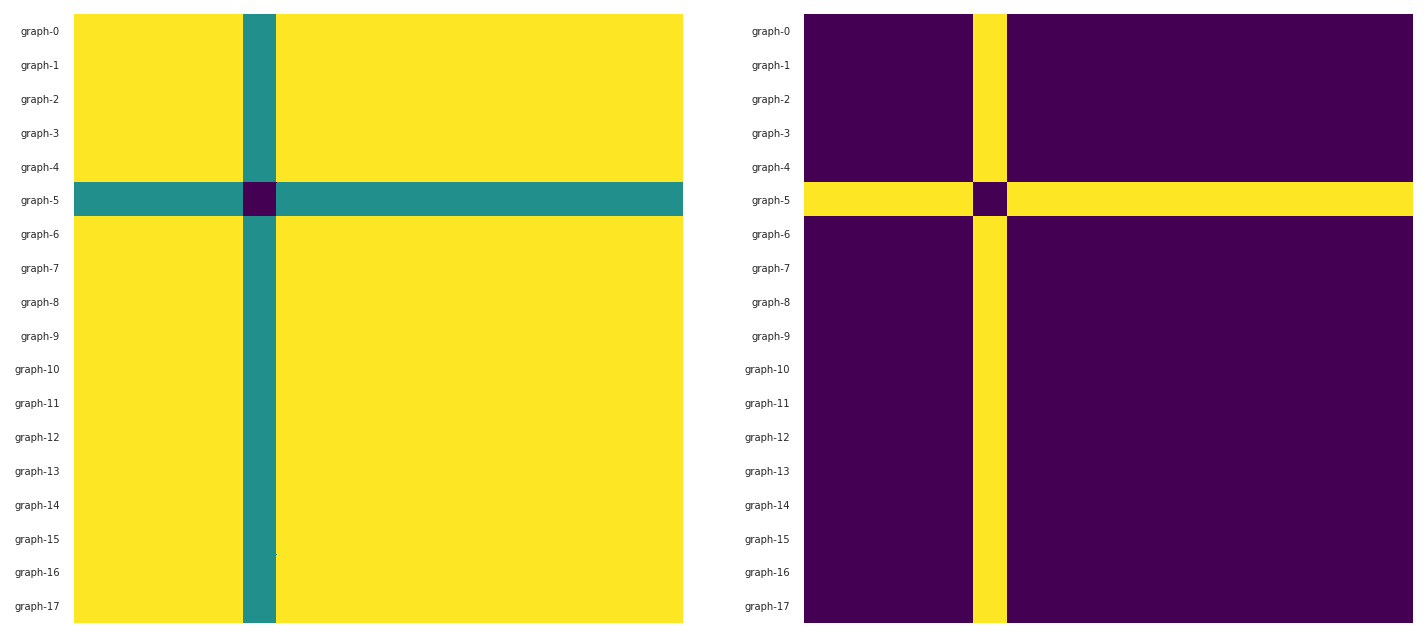

In [14]:
names, graphs = [],[]
for i in range( 0, 18, 1 ) :
    names.append( 'graph-' + str(i) )
    graphs.append( SLT.to_igraph( swaps=i ) )

K = gk.CalculateConnectedGraphletKernel( graphs )

d = zeros( K.shape )
for i in range( K.shape[0] ) :
    for j in range( K.shape[1] ) :
        d[i,j] = sqrt( K[j,j] - 2*K[j,i] + K[i,i] )

figure( figsize=(12,6) )

subplot(1,2,1)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( K, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )

subplot(1,2,2)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( d, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )

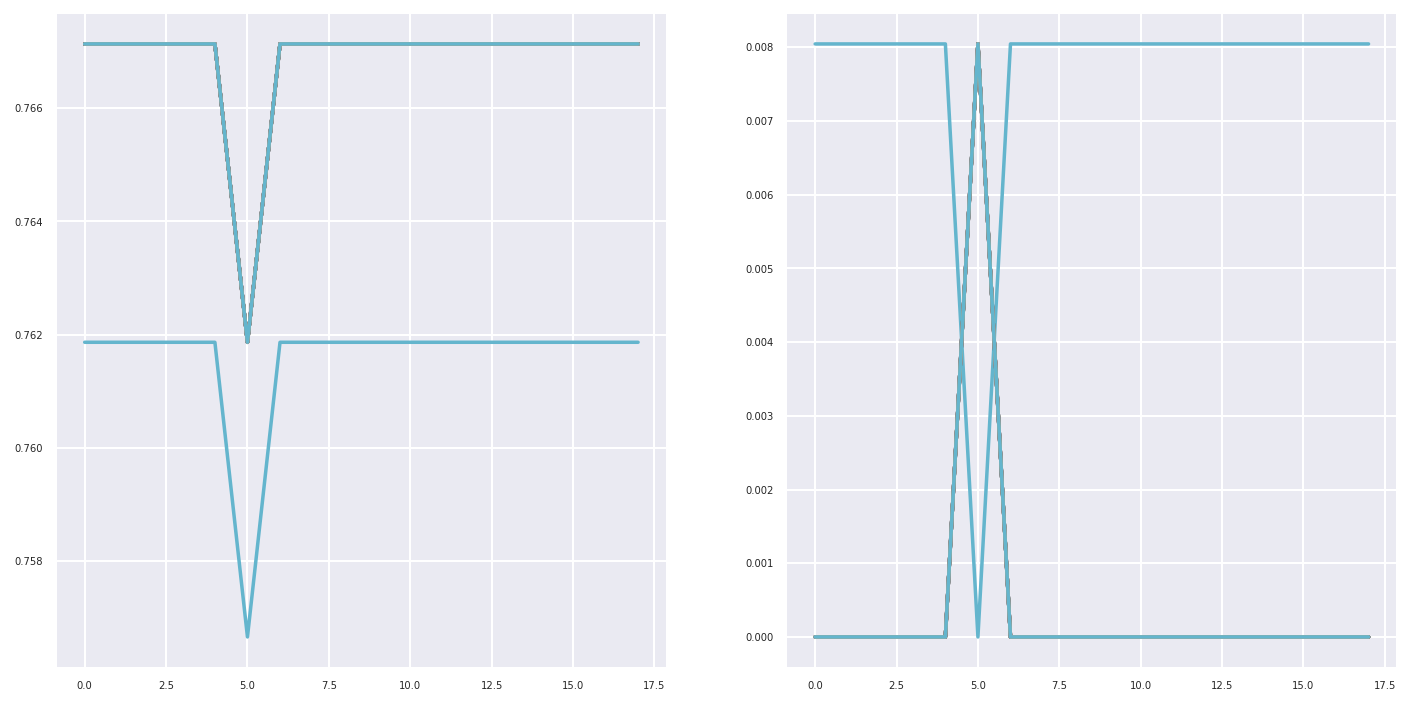

In [15]:
figure( figsize=(12,6) )

subplot(1,2,1)
for i in range( 0, 18, 1 ) :
    plot( K[i] )
    
subplot(1,2,2)
for i in range( 0, 18, 1 ) :
    plot( d[i] )

The [Weisfeiler-Lehman](http://blog.smola.org/post/33412570425/the-weisfeiler-lehman-algorithm-and-estimation-on) subtree kernel seems to pick out something a lot more interesting, though...

/home/russell/opt/lib/python2.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


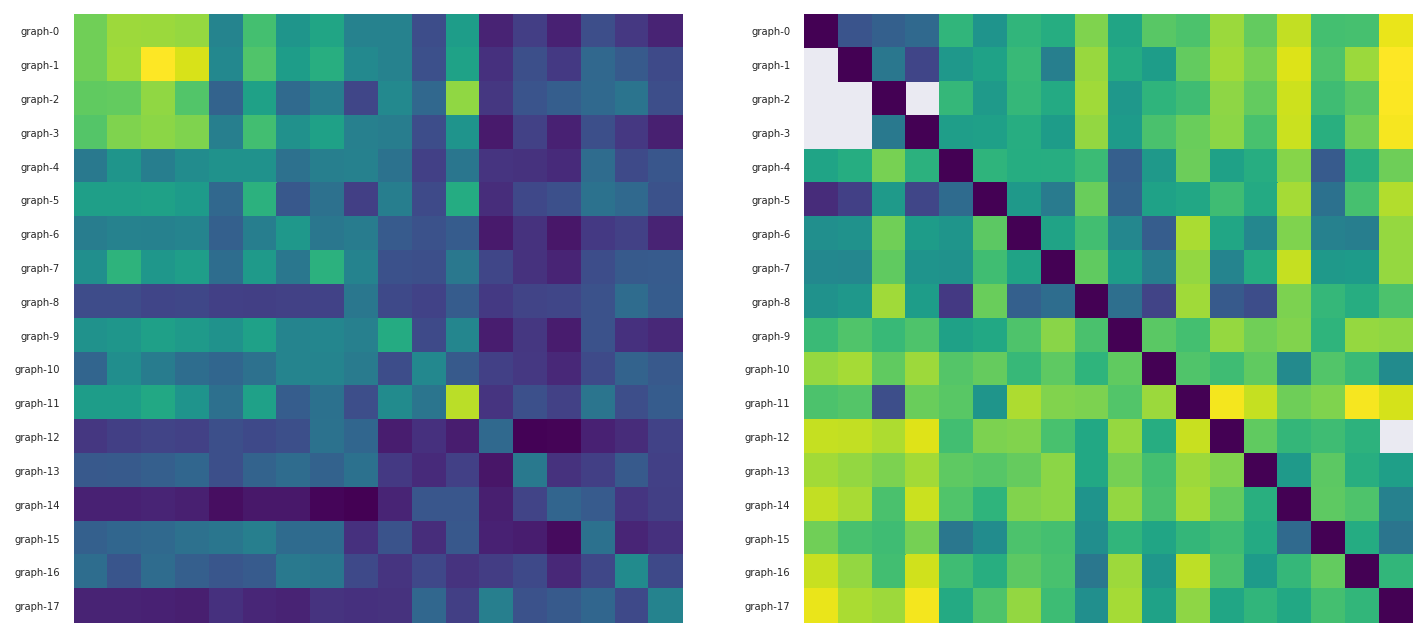

In [26]:
names, graphs = [],[]
for i in range( 0, 18, 1 ) :
    names.append( 'graph-' + str(i) )
    graphs.append( SLT.to_igraph( swaps=i ) )

K = gk.CalculateWLKernel( graphs )

d = zeros( K.shape )
for i in range( K.shape[0] ) :
    for j in range( K.shape[1] ) :
        d[i,j] = sqrt( K[j,j] - 2*K[j,i] + K[i,i] )

figure( figsize=(12,6) )

subplot(1,2,1)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( K, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )
subplot(1,2,2)
seaborn.set( font_scale=0.5 )
seaborn.heatmap( d, cmap='viridis',
                    xticklabels=False, yticklabels=names,
                    cbar=False, square=True )

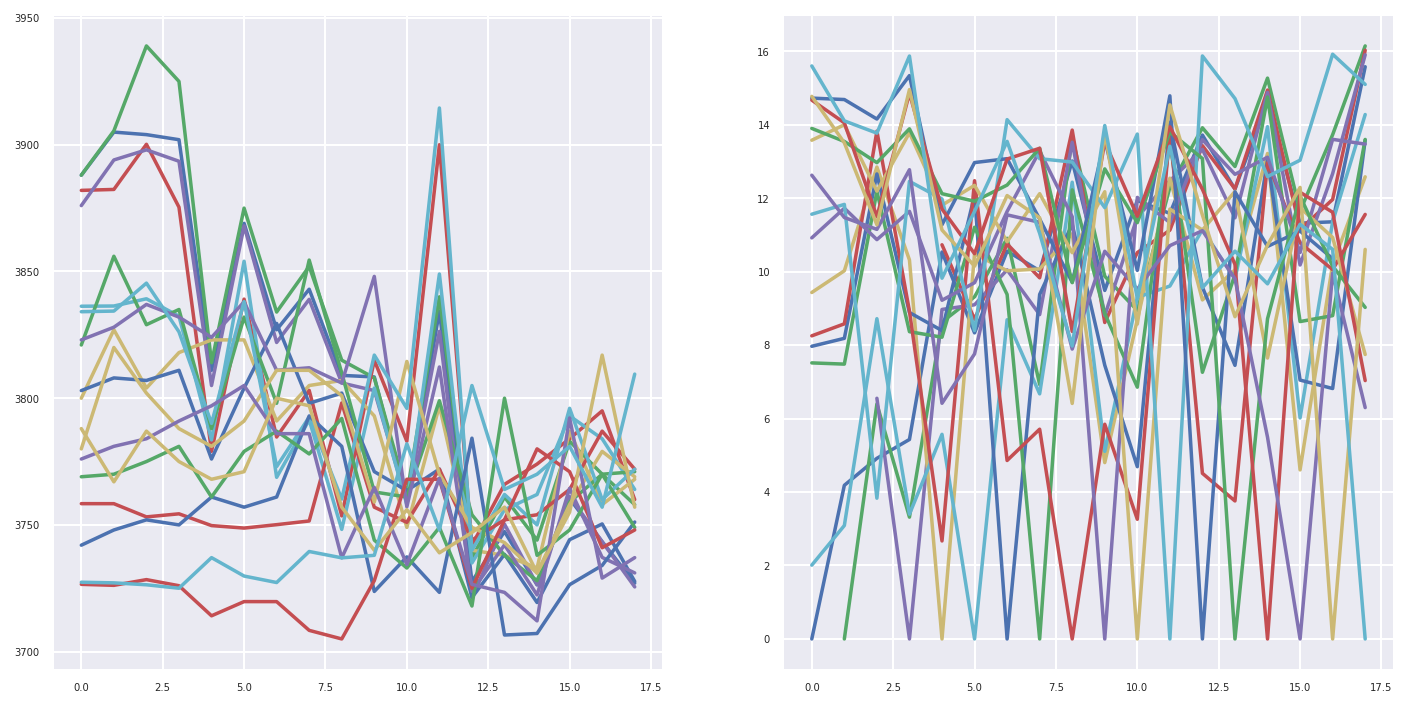

In [27]:
figure( figsize=(12,6) )

subplot(1,2,1)
for i in range( 0, 18, 1 ) :
    plot( K[i] )
    
subplot(1,2,2)
for i in range( 0, 18, 1 ) :
    plot( d[i] )

This looks a little different from the progressive additions and deletions because it
saturates. Once the links between the two trees have been throughly scrambled, the
resulting scrambled graphs resembled each other more than less-scrambled graphs.